In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import requests
import cv2

from scipy.ndimage import convolve, median_filter, gaussian_filter
from scipy.fft import fft2, fftshift
from skimage.util import random_noise
from sklearn.metrics import mean_squared_error
from PIL import Image
from io import BytesIO
from pprint import pprint
from scipy.ndimage import binary_fill_holes

In [2]:
# Seed Selection Function based on Maximum Intensity
def select_seeds(image, block_size=8, num_seeds=5):
    rows, cols = image.shape[:2]
    max_intensities = []
    block_centers = []

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
            block = image[i:i+block_size, j:j+block_size]
            max_intensity = np.max(block)
            max_intensities.append(max_intensity)
            block_centers.append((i + block_size // 2, j + block_size // 2))  # Note: (x, y) format

    top_blocks = np.argsort(max_intensities)[-num_seeds:]
    seeds = [block_centers[i] for i in top_blocks]

    return seeds

In [3]:
def region_growing_v2(image, seed=None, threshold_factor=0.1, fill_holes=True):
    """
    Perform region growing algorithm on a grayscale image using histogram and CDF for dynamic thresholding.

    Parameters:
    image (numpy.ndarray): Grayscale image.
    seed (tuple): Starting point (x, y) for region growing. If None, the seed will be chosen automatically.
    threshold_factor (float): Factor to determine dynamic threshold based on intensity range.

    Returns:
    numpy.ndarray: Segmented image.
    """
    # Image dimensions
    rows, cols = image.shape

    # If seed is not specified, select it based on intensity
    if seed is None:
        seed = np.unravel_index(np.argmax(image, axis=None), image.shape)

    # Get the intensity of the seed point
    seed_intensity = image[seed]

    # Determine the dynamic threshold based on the intensity at the seed point
    intensity_range = np.max(image) - np.min(image)
    dynamic_threshold = intensity_range * threshold_factor

    # Initialize segmented output image
    segmented = np.zeros_like(image, dtype=int)

    # List of pixels that need to be examined, starting with the seed point
    pixel_list = [seed]

    # Region growing algorithm
    while pixel_list:
        x, y = pixel_list.pop(0)
        if not segmented[x, y]:
            segmented[x, y] = 255
            # Check the 8-neighbors
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    # Skip the current pixel
                    if dx == 0 and dy == 0:
                        continue
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < rows and 0 <= ny < cols:
                        if abs(int(image[nx, ny]) - seed_intensity) < dynamic_threshold:
                            pixel_list.append((nx, ny))
    
    # Function to perform fill holes operation
    def fill_holes(segmented_image):
        # Fill holes using binary fill holes operation
        filled_image = binary_fill_holes(segmented_image).astype(int)
        return filled_image
    
    if fill_holes:
        segmented = fill_holes(segmented)
    segmented = (segmented * 255).astype(np.uint8)

    return segmented, seed

In [4]:
def region_growing_v1(image, seed=None, threshold=10, fill_holes=True):
    """
    Perform region growing algorithm on a grayscale image.

    Parameters:
    image (numpy.ndarray): Grayscale image.
    seed (tuple): Starting point (x, y) for region growing. If None, the seed will be chosen automatically.
    threshold (int): Threshold for determining pixel similarity.

    Returns:
    numpy.ndarray: Segmented image.
    """
    # Image dimensions
    rows, cols = image.shape

    # If seed is not specified, select it based on intensity
    if seed is None:
        seed = np.unravel_index(np.argmax(image, axis=None), image.shape)

    # Initialize segmented output image
    segmented = np.zeros_like(image, dtype=int)

    # List of pixels that need to be examined
    pixel_list = [seed]

    # Region growing algorithm
    while len(pixel_list) > 0:
        x, y = pixel_list.pop(0)
        if not segmented[x, y]:
            segmented[x, y] = 255
            # Check the 8-neighbors
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < rows and 0 <= ny < cols:
                        if abs(int(image[nx, ny]) - int(image[x, y])) < threshold:
                            pixel_list.append((nx, ny))
                            
    # Function to perform fill holes operation
    def fill_holes(segmented_image):
        # Fill holes using binary fill holes operation
        filled_image = binary_fill_holes(segmented_image).astype(int)
        return filled_image
    
    if fill_holes:
        segmented = fill_holes(segmented)
    segmented = segmented.astype(np.uint8)

    return segmented, seed

In [5]:
def region_growing_v3(image, seed=None, initial_threshold_factor=0.3, adjustment_factor=0.05, fill_holes=True):
    """
    Perform region growing algorithm on a grayscale image with dynamic threshold adjustment.

    Parameters:
    image (numpy.ndarray): Grayscale image.
    seed (tuple): Starting point (x, y) for region growing. If None, the seed will be chosen automatically.
    initial_threshold_factor (float): Initial factor to determine dynamic threshold based on intensity range.
    adjustment_factor (float): Factor to adjust the threshold during the growing process.

    Returns:
    numpy.ndarray: Segmented image.
    """
    rows, cols = image.shape
    if seed is None:
        seed = np.unravel_index(np.argmax(image, axis=None), image.shape)

    intensity_range = np.max(image) - np.min(image)
    dynamic_threshold = intensity_range * initial_threshold_factor

    segmented = np.zeros_like(image, dtype=bool)
    pixel_list = [seed]

    while pixel_list:
        x, y = pixel_list.pop(0)
        if not segmented[x, y]:
            segmented[x, y] = True
            region_mean = np.mean(image[segmented])
            region_std = np.std(image[segmented])

            # Adjust the dynamic threshold based on the mean and standard deviation of the segmented region
            dynamic_threshold = max(region_std * adjustment_factor, dynamic_threshold)

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < rows and 0 <= ny < cols:
                        if abs(int(image[nx, ny]) - region_mean) < dynamic_threshold:
                            pixel_list.append((nx, ny))

    # Function to perform fill holes operation
    def fill_holes(segmented_image):
        # Fill holes using binary fill holes operation
        filled_image = binary_fill_holes(segmented_image).astype(int)
        return filled_image
    
    if fill_holes:
        segmented = fill_holes(segmented)
    segmented = segmented.astype(np.uint8)
    
    return segmented, seed

In [6]:
def draw_intersection_of_binary_images_v3(image1, image2):
    """
    Draw the intersection of two binary images, where intersection is red, non-intersection is white,
    and background is black.

    Parameters:
    image1, image2 (numpy.ndarray): Two binary images of the same size.

    Returns:
    numpy.ndarray: Image highlighting the intersection in red, non-intersection in white, and background in black.
    """
    if image1.shape != image2.shape:
        raise ValueError("The input images must have the same size")

    # Create an image to display the result
    result_image = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)

    # Intersection (red)
    intersection = (image1 > 0) & (image2 > 0)
    result_image[intersection] = [255, 0, 0]

    # Non-intersecting parts of the images (white)
    non_intersection = ((image1 > 0) | (image2 > 0)) & ~intersection
    result_image[non_intersection] = [255, 255, 255]

    # Background remains black (as initialized)

    return result_image

In [7]:
# Function to draw a '+' sign
def draw_plus_sign(image, center, color, size=8, thickness=2):
    y, x = center
    cv2.line(image, (x - size, y), (x + size, y), color, thickness)
    cv2.line(image, (x, y - size), (x, y + size), color, thickness)
    # Draw yellow circle at the center
    cv2.circle(image, (x, y), 2, (0, 255, 255), -1)  # Yellow circle

In [8]:
from eval_metrics.seg_eval_metrics import (
    IoU,
    dice_similarity,
    extra_fraction,
    overlap_fraction,
    accuracy,
    specificity,
    root_mean_squared_error,
)

def compute_all_metrics(y_true, y_pred):
    eval_metrics = [
        ('IoU', IoU),
        ('Dice Similarity', dice_similarity),
        ('Extra Fraction', extra_fraction),
        ('Overlap Fraction', overlap_fraction),
        ('Accuracy', accuracy),
        ('Specificity', specificity),
        ('RMSE', root_mean_squared_error),
    ]
    
    results = {}
    for metric_name, metric_func in eval_metrics:
        results[metric_name] = metric_func(y_true, y_pred)
    
    return results

In [9]:
def overlay_seeds(img, seeds, legend=False):
    if len(img.shape) == 2:
        # copy flair_image and make it three channels
        img = np.dstack([img] * 3)
    
    # Colors for each seed
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]  # Red, Green, Blue

    #  Draw each seed
    for i, seed in enumerate(seeds):
        draw_plus_sign(img, seed, colors[i])
        
    if legend:
        # Add a legend in a for loop
        for i, color in enumerate(colors):
            cv2.putText(img, f'Seed #{i+1}', (10, 10 + 10 * i), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1)
    
    return img

In [10]:
def overlay_mask(image, pred_mask, gt_mask, seed=None):
    """
    Overlays the outline of a segmentation mask on the original image.

    Args:
    image (numpy.ndarray): The original image.
    mask (numpy.ndarray): The segmentation mask.

    Returns:
    numpy.ndarray: The original image with the mask outline overlaid.
    """
    
    # copy flair_image and make it three channels
    img_3_channels = np.dstack([image] * 3)

    # Ensure the mask is in uint8 format
    pred_mask_uint8 = pred_mask.astype(np.uint8) * 255
    gt_mask_uint8 = gt_mask.astype(np.uint8) * 255

    # Find contours of the mask
    pred_contours, _ = cv2.findContours(pred_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    gt_contours, _ = cv2.findContours(gt_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the original image
    overlayed_image = np.copy(img_3_channels)
    cv2.drawContours(overlayed_image, gt_contours, -1, (0, 255, 0), 2)  # Green contours
    cv2.drawContours(overlayed_image, pred_contours, -1, (255, 0, 0), 2)  # Red contours
    
    overlayed_image = overlay_seeds(overlayed_image, [seed])
    
    cv2.putText(overlayed_image, f'Groundtruth', (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 0), 1)
    cv2.putText(overlayed_image, f'Prediction', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 0, 0), 1)

    return overlayed_image

In [11]:
def average_dataset_metrics(data):
    total_metrics = {
        'IoU': 0, 
        'Dice Similarity': 0, 
        'Extra Fraction': 0,
        'Overlap Fraction': 0, 
        'Accuracy': 0, 
        'Specificity': 0, 
        'RMSE': 0
    }

    # Loop through each image and sum up the metrics of the "best" images
    for image_id, metrics in data.items():
        best_metrics = metrics['best']
        for metric in total_metrics:
            total_metrics[metric] += best_metrics[metric]

    # Compute the average for each metric
    average_metrics = {metric: total / len(data) for metric, total in total_metrics.items()}
    return average_metrics

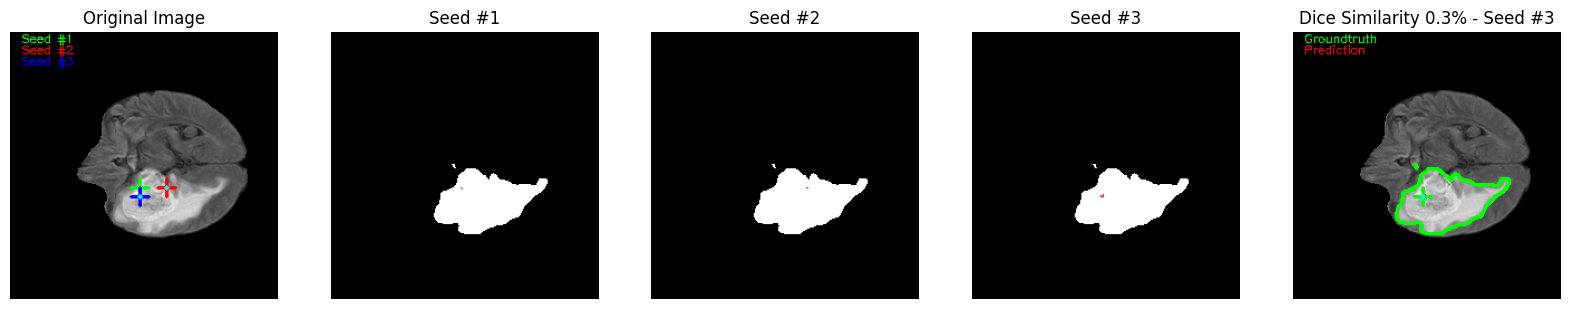

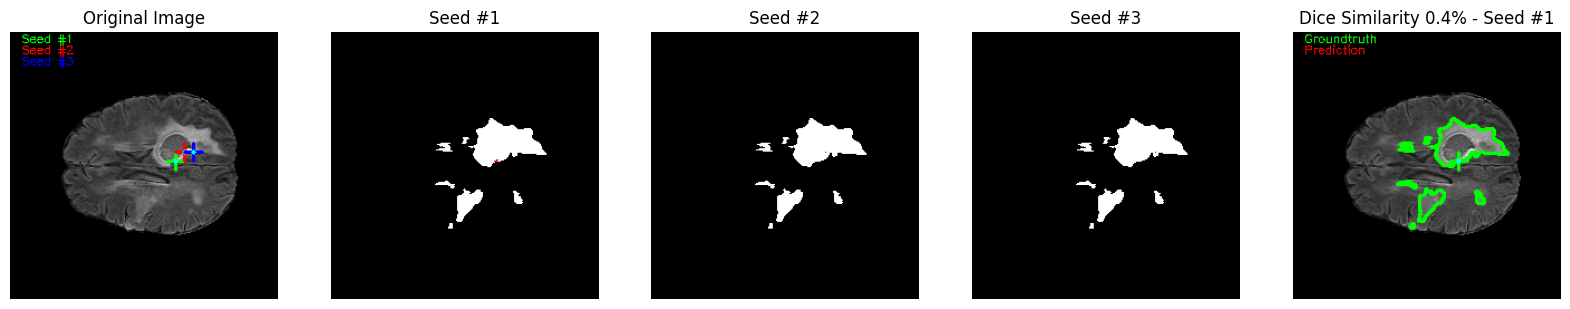

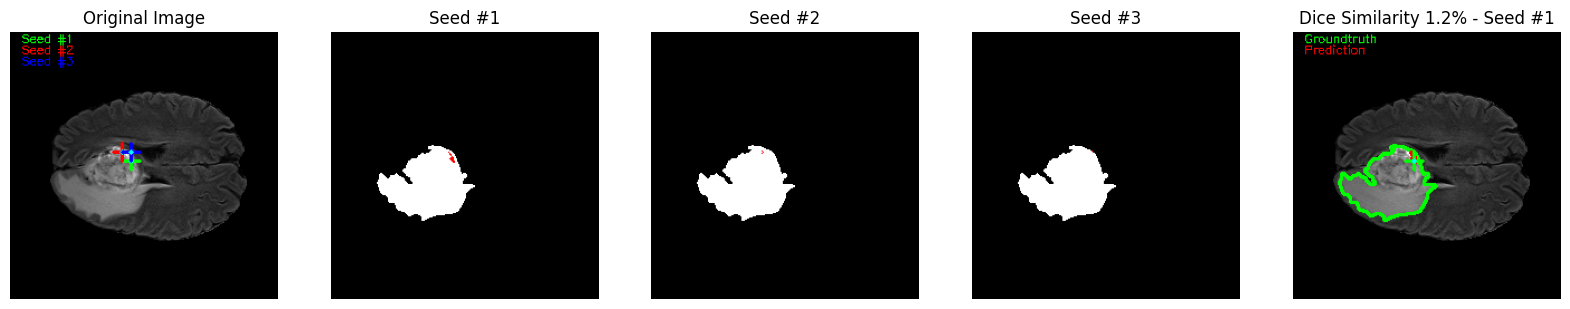

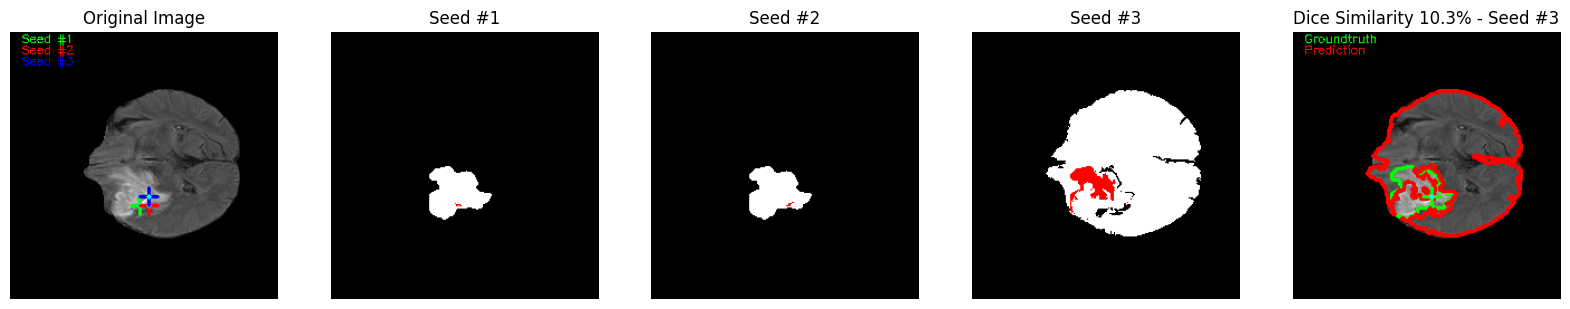

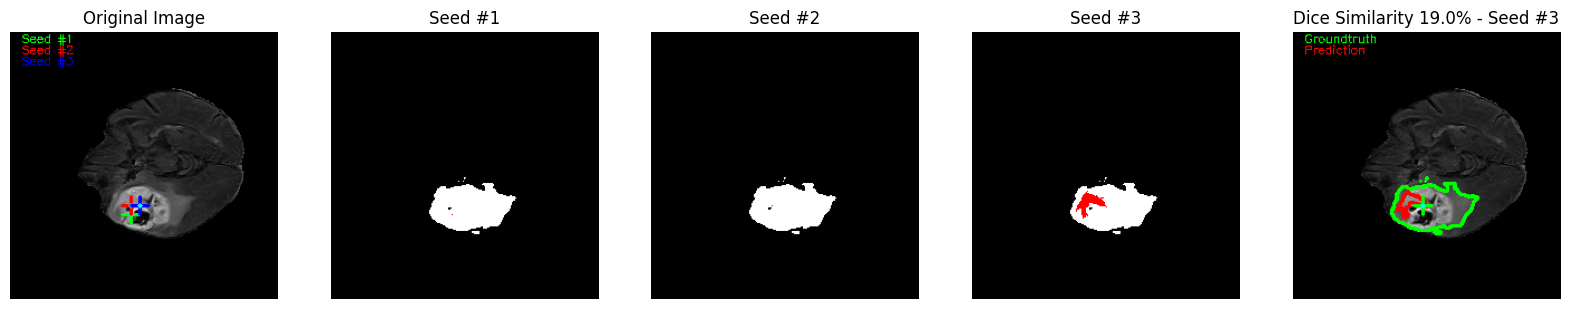

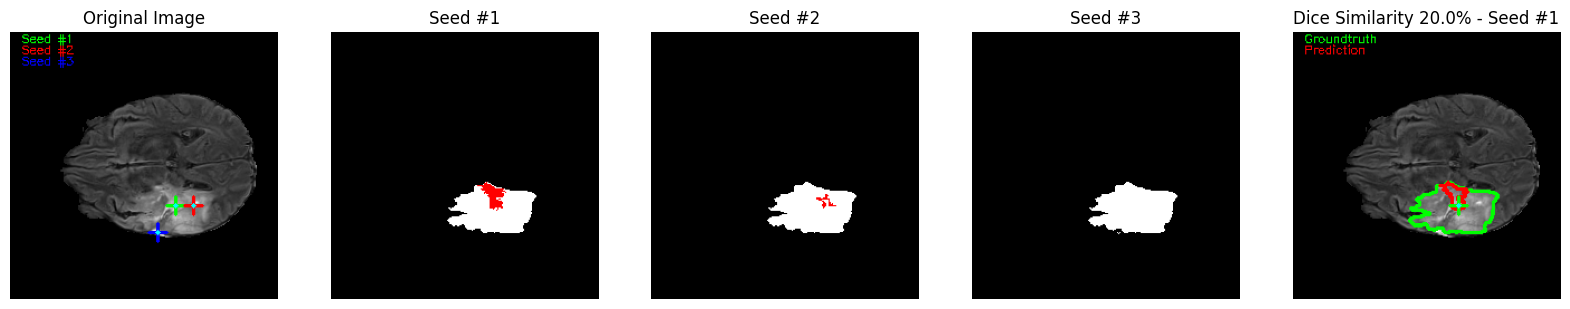

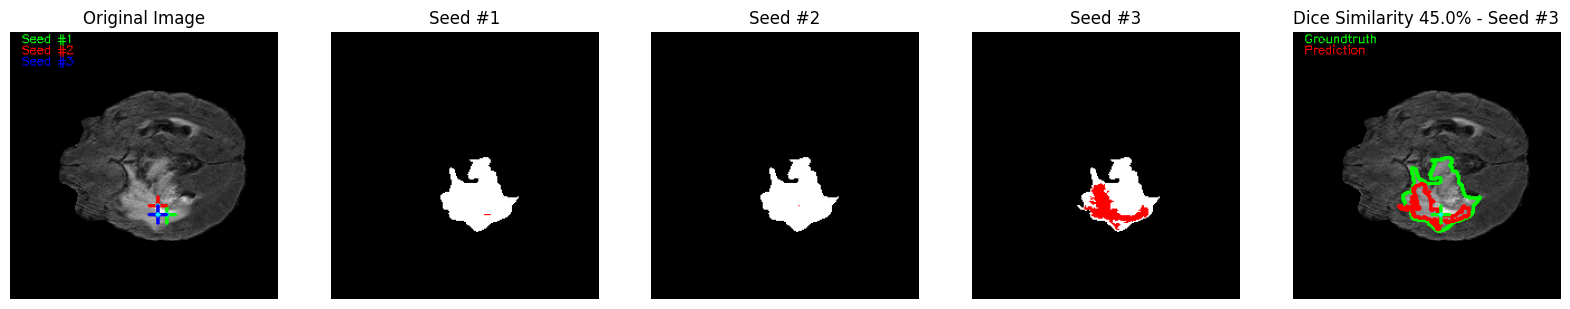

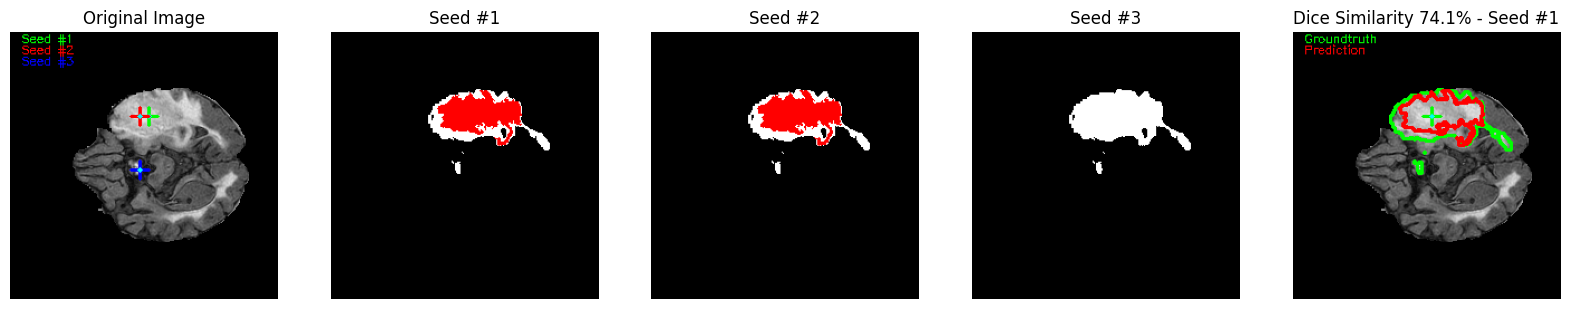

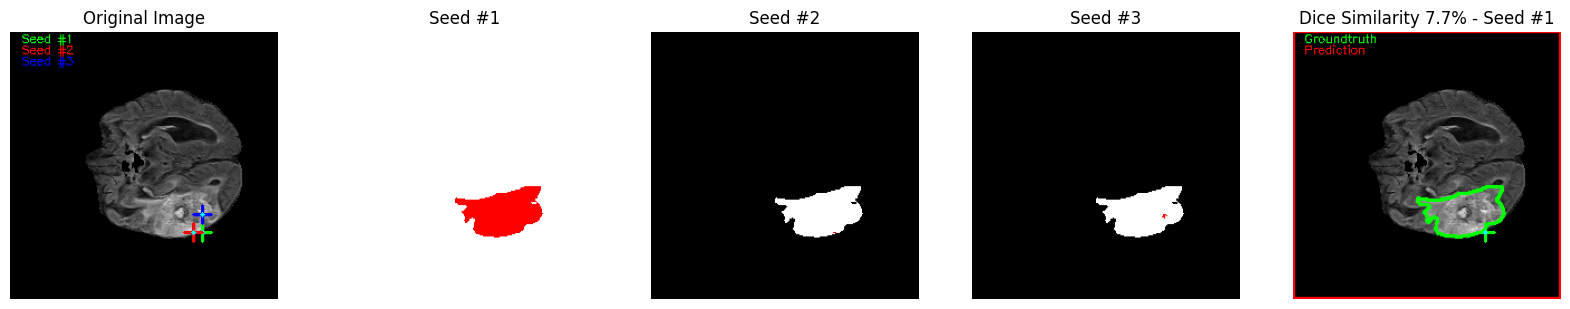

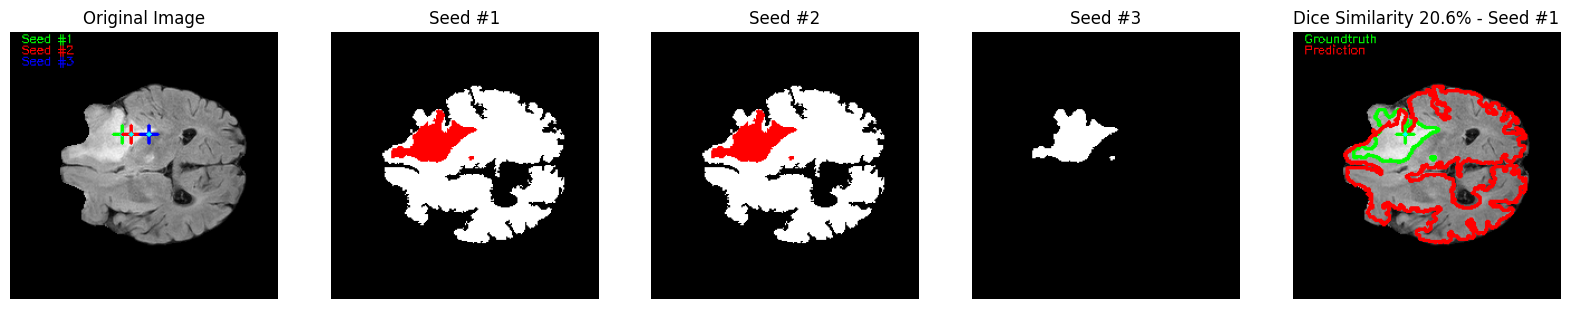

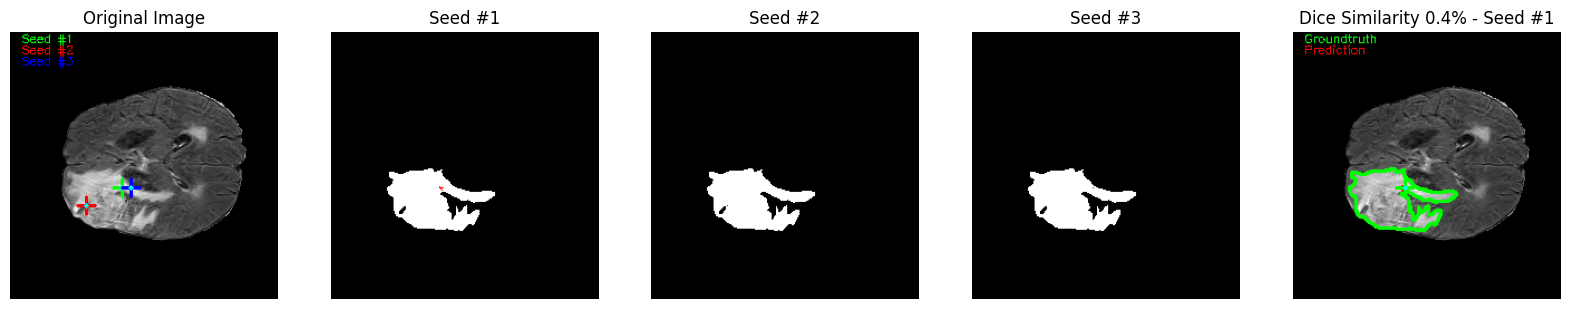

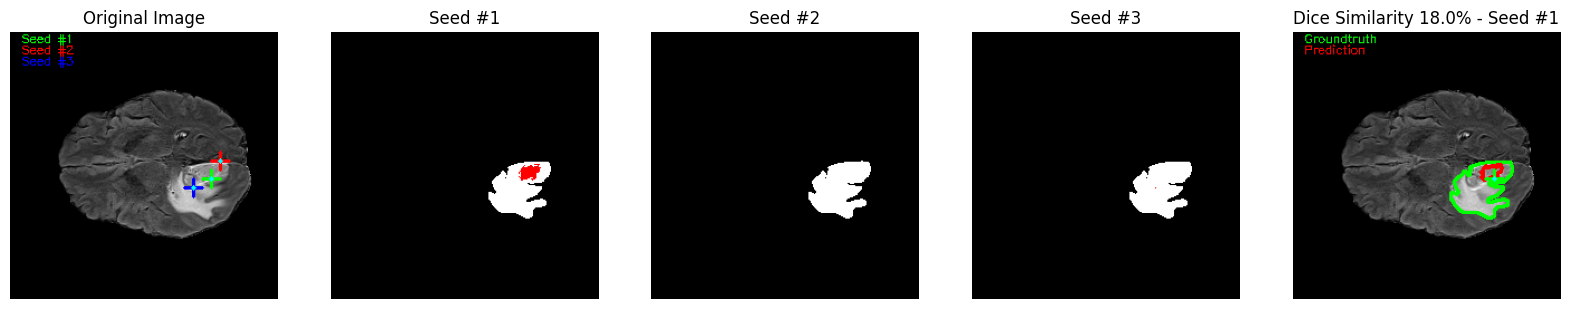

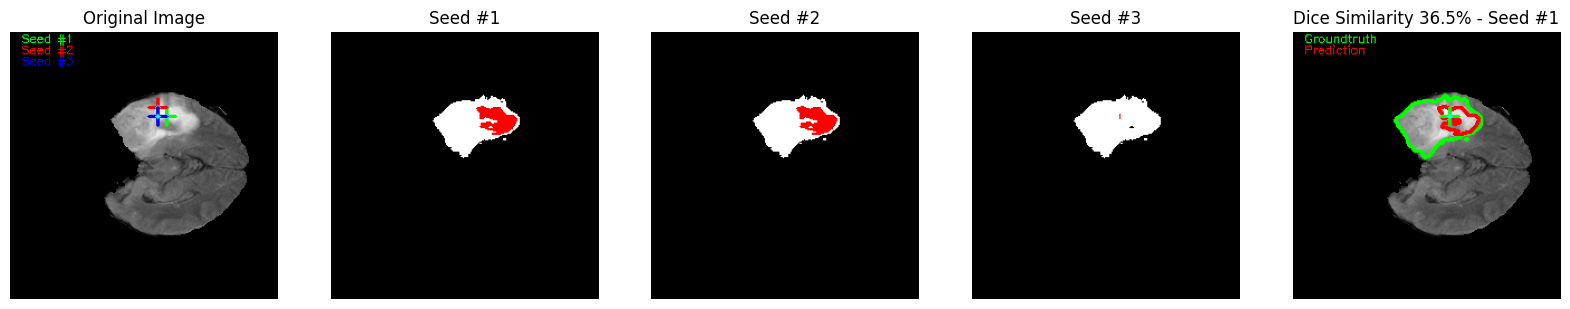

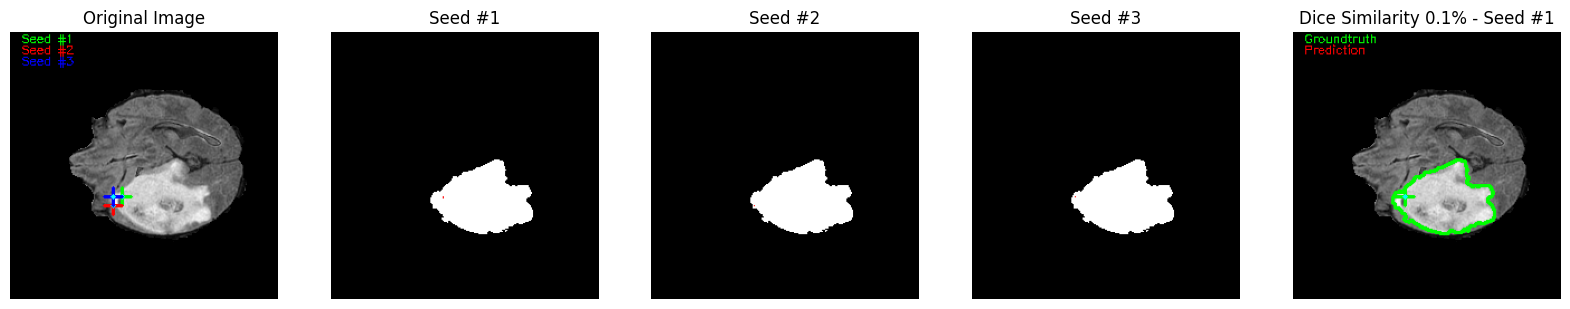

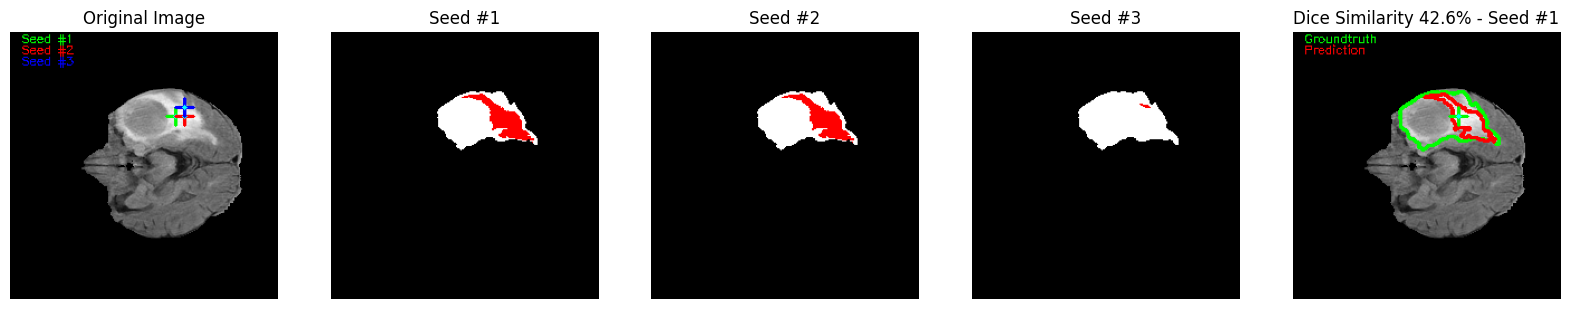

In [12]:
dataset_path = 'Images/Raw Images/Dataset2/Set2/'
results_path = 'Images/results_set1/enhanced_region_growing_v1/Set2/'
all_metrics = {}

for id, data_folder in enumerate(os.listdir(dataset_path)):
    data_folder_path = os.path.join(dataset_path, data_folder)
    # flair_path should be the file inside the data_folder_path that contains the word flair and ends with .png
    flair_path = os.path.join(data_folder_path, [file for file in os.listdir(data_folder_path) if 'flair' in file and file.endswith('.png')][0])
    # gt_path should be the file inside the data_folder_path that contains exactly the word seg and ends with .png
    gt_path = os.path.join(data_folder_path, [file for file in os.listdir(data_folder_path) if 'seg.' in file and file.endswith('.png')][0])

    flair_image = cv2.imread(flair_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    # Get seeds
    seeds = select_seeds(flair_image, block_size=8, num_seeds=3)

    all_results = []

    for i, seed in enumerate(seeds):
        segmented, _ = region_growing_v1(flair_image, seed=seed, threshold=6)
        # segmented, _ = region_growing_v2(flair_image, seed=seed, threshold_factor=0.3)
        # segmented, _ = region_growing_v3(flair_image, seed=seed, initial_threshold_factor=0.15, adjustment_factor=0.05, fill_holes=False)
        all_results.append((segmented, 'Seed #{}'.format(i+1)))

    all_intersections = []
    metrics = {}
    best_segmentation, best_dice_similarity, best_seed_id, best_seed = None, 0, None, None

    for i, (result, name) in enumerate(all_results):
        intersection = draw_intersection_of_binary_images_v3(gt_mask, result)
        all_intersections.append((intersection, name))
        
        metrics[i] = compute_all_metrics(gt_mask, result)
        
        if metrics[i]['Dice Similarity'] > best_dice_similarity:
            best_dice_similarity = metrics[i]['Dice Similarity']
            best_segmentation = result
            best_seed_id = i
            best_seed = seeds[i]
            metrics['best'] = {**metrics[i], **{'seed': best_seed_id}}
        
    all_metrics[id + 1] = metrics

    all_intersections.insert(0, (overlay_seeds(flair_image, seeds, legend=True), 'Original Image'))
    all_intersections.append((overlay_mask(flair_image, pred_mask=best_segmentation, gt_mask=gt_mask, seed=best_seed), 'Dice Similarity {:.1f}% - Seed #{}'.format(best_dice_similarity * 100, best_seed_id + 1)))
        
    # plot all of them side by side
    fig, ax = plt.subplots(1, len(all_intersections), figsize=(20, 20))

    for i, (intersection, name) in enumerate(all_intersections):
        ax[i].imshow(intersection)
        ax[i].set_title(name)
        ax[i].axis('off')

    plt.savefig(results_path + data_folder + '.png', bbox_inches='tight')
    plt.show()
    
all_metrics['average'] = average_dataset_metrics(all_metrics)
        
# Save all metrics to json file
with open(results_path + 'all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)